# Настройка среды

In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

In [ ]:
from belashovplot import TiledPlot
from utilities import *
from utilities.filters import Gaussian, Window
from utilities.training import train, confusion
from elements.modulators import Lens, PhaseModulator, AmplitudeModulator
from elements.propagators import FurrierPropagation, ConvolutionalPropagation
from elements.composition import CompositeModel, HybridModel
from elements.wrappers import CudaMemoryChunker, Incoherent
from elements.detectors import ClassificationDetectors, MatrixDetectors
from parameters import FigureWidthHeight, FontLibrary
from tqdm import tqdm
from math import sin, sqrt
from pickle import dump
import torch
import numpy
import matplotlib.pyplot as plt

In [3]:
FontLibrary.Fonts.PlotTitle.FontSize = 16
FontLibrary.Fonts.DescriptionLeft.FontSize = 12
FontLibrary.Fonts.DescriptionLeft.FontWeight = 'bold'
FontLibrary.Fonts.DescriptionLeft.FontStyle = 'italic'
FontLibrary.Fonts.ColumnDescriptionTop.FontSize = 9
FontLibrary.Fonts.ColumnDescriptionBottom.FontSize = 9
FontLibrary.Fonts.RowDescriptionLeft.FontSize = 9
FontLibrary.Fonts.RowDescriptionRight.FontSize = 9
FontLibrary.Fonts.AxisX.FontSize = 8
FontLibrary.Fonts.AxisY.FontSize = 8
FigureWidthHeight = (6.69291, 10.1181)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Используемый девайс:', torch.cuda.get_device_name(device) if torch.cuda.is_available() else 'ЦП')

Используемый девайс: NVIDIA GeForce RTX 3060 Ti


# Примеры генерации случайной фазы

In [9]:
ref_spatial_coherence = 50.0E-6
ref_length = 10.0E-3
ref_time_coherence = 10.0E-9
ref_time_relaxation = 1.0E-6
ref_mean_samples = 40
N = 1000

In [6]:
spatial_coherence_list = numpy.array([50.0E-6, 500.0E-6, 1.0E-3, 10.0E-3])

realizations_list = []
autocorrelations_list = []
distributions_list = []
normalized_distributions_list = []

for spatial_coherence in tqdm(spatial_coherence_list):
    incoherent = Incoherent(spatial_coherence, ref_time_coherence, ref_time_relaxation, ref_mean_samples, N, ref_length).to(device)
    incoherent.delayed.launch()
    with torch.no_grad():
        realization = incoherent._generator.sample()
        distribution, values = incoherent._generator.distribution_fixed(True)
        normalized_distribution, normalized_values = incoherent._generator.distribution(True)
        autocorr = autocorrelation(realization[:, ::4, ::4], dims=(1,2), mean_dim=0, split=ref_mean_samples)
        radius, position = correlation_circle(autocorr, ((0, ref_length), (0, ref_length)))
        autocorr = autocorr[int(N//4*position[0]/ref_length)]
        autocorr = (autocorr - autocorr.min()) / (autocorr.max() - autocorr.min())
        
        realizations_list.append(realization[0].cpu())
        autocorrelations_list.append((autocorr.cpu(), radius))
        distributions_list.append((distribution.cpu(), values.cpu()))
        normalized_distributions_list.append((normalized_distribution.cpu(), normalized_values.cpu()))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:49<00:00, 12.37s/it]


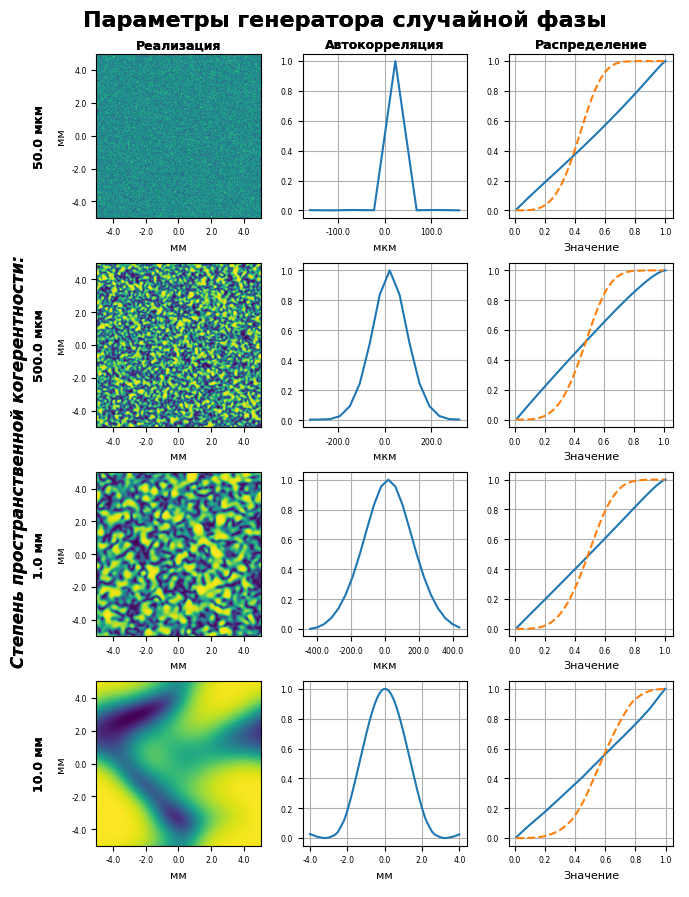

In [8]:
plot = TiledPlot(*FigureWidthHeight)
plot.FontLibrary = FontLibrary
plot.title('Параметры генератора случайной фазы')
plot.description.column.top("Реализация", 0)
plot.description.column.top("Автокорреляция", 1)
plot.description.column.top("Распределение", 2)
plot.description.left("Степень пространственной когерентности:")
plot.pad.description.row.left(0.1)
plot.pad.description.left(0.05)
plot.pad.graph.vertical(0.1)

formatter, unit = engineering.separatedformatter(ref_length/2, 'м')

for row, (spatial_coherence, realization, (autocorr, radius), (distribution, values), (normalized_distribution, normalized_values)) in enumerate(zip(spatial_coherence_list, realizations_list, autocorrelations_list, distributions_list, normalized_distributions_list)):
    M = autocorr.shape[0]
    dn = int(4*M*radius/ref_length)
    if dn >= M//2: dn = M//2
    x_array = torch.linspace(-ref_length*dn/M, +ref_length*dn/M, 2*dn)
    autocorr = autocorr[M//2-dn:M//2+dn]

    formatter_autocorr, unit_autocorr = engineering.separatedformatter(2*radius, 'м')
    
    plot.description.row.left(engineering(spatial_coherence, 'м', 1), row)
    
    axes = plot.axes.add(0, row)
    axes.xaxis.set_major_formatter(formatter)
    axes.yaxis.set_major_formatter(formatter)
    axes.imshow(realization, aspect='auto', extent=[-ref_length/2, +ref_length/2]*2)
    plot.graph.label.x(unit)
    plot.graph.label.y(unit)

    axes = plot.axes.add(1, row)
    axes.xaxis.set_major_formatter(formatter_autocorr)
    axes.grid(True)
    axes.plot(x_array, autocorr)
    plot.graph.label.x(unit_autocorr)

    axes = plot.axes.add(2, row)
    axes.grid(True)
    axes.plot(values, distribution)
    axes.plot(normalized_values, normalized_distribution, linestyle='--')
    plot.graph.label.x('Значение')
plot.save('../figures/IncoherentRAD.eps')
plot.show()